In [1]:
import numpy as np
import pandas as pd
import random
import math
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
import sklearn as sk
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def getData(df):
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change']]
    high = df['High']
    low = df['Low']
    change = df['Change']
    change_array = []
    delist_array = []
    for i in range(len(df)):
        if high[i] != low[i]:
            delist_array.append(1)
            if change[i] > 0.1:
                change_array.append(0.1)
            elif change[i] < -0.1:
                change_array.append(-0.1)
            else:
                change_array.append(change[i])
        else:
            delist_array.append(0)
    df['Change_update'] = pd.DataFrame(change_array)
    df['delist'] = pd.DataFrame(delist_array)
    
    # 去除当日停牌数据
    df = df[df['delist'].isin([1])]
    return df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change_update']]

def min_max_range(x, range_values):
    return [round( ((xx - min(x)) / (1.0*(max(x) - min(x))))
                  * (range_values[1] - range_values[0]) + range_values[0], 2) for xx in x]

def DataProcess(df):
    df  = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change_update']]
    
    data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Change_update']].values
    label = df['Change_update'].values
    
    open_data = df['Open'].values
    high_data = df['High'].values
    low_data = df['Low'].values
    close_data = df['Close'].values
    volume_data = df['Volume'].values
    change_data = df['Change_update'].values
    
    open_data = min_max_range(open_data, (0, 255))
    high_data = min_max_range(high_data, (0, 255))
    low_data = min_max_range(low_data, (0, 255))
    close_data = min_max_range(close_data, (0, 255))
    volume_data = min_max_range(volume_data, (0, 255))
    change_data = min_max_range(change_data, (0, 255))
    df['open_1'] = pd.DataFrame(open_data)
    df['high_1'] = pd.DataFrame(high_data)
    df['low_1'] = pd.DataFrame(low_data)
    df['close_1'] = pd.DataFrame(close_data)
    df['volume_1'] = pd.DataFrame(volume_data)
    df['change_1'] = pd.DataFrame(change_data)
    
    df = df[['open_1', 'high_1', 'low_1', 'close_1', 'volume_1', 'change_1']]
    
    label_array = []
    for i in range(len(label)):
        if label[i] >= 0:
            label_array.append(1)
        else:
            label_array.append(0)
    return df, label_array

def win(data, label, PastDays):
    newt = []
    newtr = []
    newtl = []
    newl = []
    for i in range(len(data)-PastDays+1):
        for j in range(PastDays):
            if(j < PastDays-1):                
                newt.append(data[i+j])
                newl.append(label[i+j])
            else:        
                newtr.append(newt)
                newtl.append(newl)
                newt = []
                newl = []
    dataset = np.array(newtr)
    labelset = np.array(newtl)
    
    # 赋予label
    # 采用每个batch中出现次数最多的数字作为这个batch的标签
    label = []
    for i in range(len(labelset)):
        tmp = list(labelset[i])
        label.append(max(set(tmp), key=tmp.count))
    
    return dataset, label

In [3]:
def acc_loss_fig(model_log):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model_log.history['acc'])
    plt.plot(model_log.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.plot(model_log.history['loss'])
    plt.plot(model_log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.tight_layout()
    plt.show()

In [4]:
stock_code = pd.read_csv("212NYSE_Composite_stock_code.csv")
stock_csv = stock_code.values

In [5]:
def data_pre_process(stock_csv):
    train_dataset = []
    test_dataset = []
    train_labelset = []
    test_labelset = []
    for stock_item in stock_csv:
        print(stock_item)
        df = pd.read_csv(stock_item[0])
        close = df['Close']
        df['Change'] = (close-close.shift(1))/close.shift(1)

        # 拆分训练数据与测试数据并获取标签
        data_num = df.shape[0]
        data = getData(df)
        data = data.dropna(axis=0)
        data_1, label_1 = DataProcess(data)
        data_1 = data_1.dropna(axis=0)
        data_values = data_1.values

        data_win, label_win = win(data_values, label_1, PastDays)

        num1 = len(data_win)
        num2 = math.floor(num1*0.70)
        data_random = list(range(0, num1))
        random.shuffle(data_random)
        train_random = data_random[0:num2]
        test_random = data_random[num2:]
        
        train_data_random = []
        test_data_random = []
        train_label_random = []
        test_label_random = []
        for item in train_random:
            train_data_random.append(data_win[item])
            train_label_random.append(label_win[item])
        for item in test_random:
            test_data_random.append(data_win[item])
            test_label_random.append(label_win[item])

        train_labelset_01 = np_utils.to_categorical(train_label_random, n_classes)
        test_labelset_01 = np_utils.to_categorical(test_label_random, n_classes)   
        
        train_dataset.append(train_data_random)
        test_dataset.append(test_data_random)
        
        train_labelset.append(train_labelset_01)
        test_labelset.append(test_labelset_01)
        
    return train_dataset, test_dataset, train_labelset, test_labelset

In [6]:
PastDays = 6
n_classes = 2
FeatureNums = 6
batch_size = 32
num_epoch = 50

n_filters = 32
kernel_size = [3, 3]
pool_size = [2, 2]

In [7]:
train_dataset, test_dataset, train_labelset, test_labelset = data_pre_process(stock_csv)

['XXII.csv']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['FAX.csv']
['IAF.csv']
['FCO.csv']
['ACU.csv']
['ATNM.csv']
['AIRI.csv']
['AXU.csv']
['ALO.csv']
['AAU.csv']
['APT.csv']
['AAMC.csv']
['DIT.csv']
['AMS.csv']
['AKG.csv']
['AWX.csv']
['ASM.csv']
['BTG.csv']
['BTN.csv']
['BKJ.csv']
['BCV.csv']
['BHB.csv']
['BRN.csv']
['BTX.csv']
['BGI.csv']
['BDR.csv']
['BRG.csv']
['CEI.csv']
['CANF.csv']
['ROX.csv']
['CVM.csv']
['CET.csv']
['LEU.csv']
['CCF.csv']
['LNG.csv']
['CVR.csv']
['CKX.csv']
['GLV.csv']
['GLQ.csv']
['GLO.csv']
['COHN.csv']
['CIX.csv']
['LODE.csv']
['CTO.csv']
['MCF.csv']
['CUO.csv']
['CVM.csv']
['CVRS.csv']
['CRMD.csv']
['CLM.csv']
['CRF.csv']
['CVU.csv']
['CIK.csv']
['DHY.csv']
['CRHM.csv']
['DXR.csv']
['VCF.csv']
['VMM.csv']
['VFL.csv']
['DLA.csv']
['DNN.csv']
['DGSE.csv']
['DSS.csv']
['DPW.csv']
['DMF.csv']
['GRF.csv']
['EVM.csv']
['CEV.csv']
['EVV.csv']
['EIM.csv']
['ENX.csv']
['EVY.csv']
['ELMD.csv']
['ELLO.csv']
['ECF.csv']
['EMAN.csv']
['MSN.csv']
['EMX.csv']
['UUUU.csv']
['ENSV.csv']
['EGI.csv']
['ESP.csv']
['EVI.csv']
[

In [8]:
from itertools import chain
train_data = list(chain(*train_dataset)) 
test_data = list(chain(*test_dataset)) 
train_label = list(chain(*train_labelset))
test_label = list(chain(*test_labelset)) 

In [11]:
import pickle

pickle_file_traindata = open('NYSE Composite_traindata.pkl','wb')   #以二进制形势打开一个文件
pickle.dump(train_data, pickle_file_traindata)      #将数据导入dump文件
pickle_file_traindata.close()                #关闭文件

pickle_file_testdata = open('NYSE Composite_testdata.pkl','wb')   
pickle.dump(test_data, pickle_file_testdata)      
pickle_file_testdata.close()               

pickle_file_trainlabel = open('NYSE Composite_trainlabel.pkl','wb')   
pickle.dump(train_label, pickle_file_trainlabel)      
pickle_file_trainlabel.close()                

pickle_file_testlabel = open('NYSE Composite_testlabel.pkl','wb')   
pickle.dump(test_label, pickle_file_testlabel)      
pickle_file_testlabel.close()                

In [13]:
#打开文件
pickle_open = open('NYSE Composite_traindata.pkl','rb')
traindata = pickle.load(pickle_open)   #重新导入数据

pickle_open = open('NYSE Composite_testdata.pkl','rb')
testdata = pickle.load(pickle_open)   #重新导入数据

pickle_open = open('NYSE Composite_trainlabel.pkl','rb')
trainlabel = pickle.load(pickle_open)   #重新导入数据

pickle_open = open('NYSE Composite_testlabel.pkl','rb')
testlabel = pickle.load(pickle_open)   #重新导入数据

pickle_open.close()

In [9]:
def model(train_data, test_data, train_label, test_label):
    img_cols = PastDays-1
    img_rows = FeatureNums
    input_shape = (img_cols, img_rows, 1)

    train_data = np.array(train_data)
    test_data = np.array(test_data)
    
    X_train = train_data.reshape(len(train_data), img_cols, img_rows, 1)
    X_test  = test_data.reshape(len(test_data), img_cols, img_rows, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    y_train = np.array(train_label)
    y_test = np.array(test_label)

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    
    if X_train.shape[0] == 0:
        return 
    else:
        # 2D model
        model = Sequential()
        model.add(Convolution2D(n_filters,
                                             kernel_size=(kernel_size[0], kernel_size[1]),
                                             input_shape=input_shape,
                                             activation='relu'))
        model.add(MaxPooling2D(pool_size=(pool_size[0], pool_size[1])))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, init='normal', activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(n_classes, init='normal', activation='softmax'))

        model.summary()

        # 保存模型的权重
        # checkpoint best neural network model only
        filepath = "2DCNN.NYSE Composite-stock all.weight.best.h5"

        # checkpoint
        checkpoint = ModelCheckpoint(filepath,
                                                     monitor='val_acc',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     mode='max')

        model.compile(loss=keras.losses.categorical_crossentropy,
                             optimizer=keras.optimizers.Adadelta(),
                             metrics=['accuracy'])

        model.save_weights(filepath)

        model_log = model.fit(X_train, y_train,
                                       batch_size=batch_size,
                                       epochs=num_epoch,
                                       verbose=1,
                                       validation_data=(X_test, y_test),
                                       callbacks=[checkpoint])
        acc_loss_fig(model_log)
    
        model.load_weights(filepath)
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_pred = np_utils.to_categorical(y_pred, n_classes)
        y_true = y_test
        F1_value = f1_score(y_true, y_pred, average='weighted')
        conf_matrix = sk.metrics.confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
        score = model.evaluate(X_test, y_test, verbose=0)
        print("F1_score = ", F1_value)
        print("confusion matrix\n", conf_matrix)
        print("Test Score = ", score[0])
        print("Test accuracy = ", score[1])
        return filepath, F1_value, conf_matrix, score[0], score[1]

(402557, 5, 6, 1) (402557, 2)
(172666, 5, 6, 1) (172666, 2)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", kernel_initializer="normal")`


Train on 402557 samples, validate on 172666 samples
Epoch 1/50
402557/402557 [==============================] - 31s 78us/step - loss: 0.6495 - acc: 0.6402 - val_loss: 0.6119 - val_acc: 0.6650
Epoch 2/50
402557/402557 [==============================] - 31s 78us/step - loss: 0.6212 - acc: 0.6679 - val_loss: 0.5982 - val_acc: 0.6904
Epoch 3/50
402557/402557 [==============================] - 32s 80us/step - loss: 0.6138 - acc: 0.6747 - val_loss: 0.6165 - val_acc: 0.6581
Epoch 4/50
402557/402557 [==============================] - 32s 80us/step - loss: 0.6100 - acc: 0.6775 - val_loss: 0.5962 - val_acc: 0.6984
Epoch 5/50
402557/402557 [==============================] - 32s 80us/step - loss: 0.6057 - acc: 0.6809 - val_loss: 0.6033 - val_acc: 0.6745
Epoch 6/50
402557/402557 [==============================] - 33s 82us/step - loss: 0.6034 - acc: 0.6819 - val_loss: 0.5896 - val_acc: 0.6959
Epoch 7/50
402557/402557 [==============================] - 33s 81us/step - loss: 0.6015 - acc: 0.6832 - val

402557/402557 [==============================] - 32s 80us/step - loss: 0.5910 - acc: 0.6901 - val_loss: 0.5987 - val_acc: 0.7036
Epoch 31/50
402557/402557 [==============================] - 31s 78us/step - loss: 0.5911 - acc: 0.6904 - val_loss: 0.5832 - val_acc: 0.6994
Epoch 32/50
402557/402557 [==============================] - 32s 80us/step - loss: 0.5909 - acc: 0.6910 - val_loss: 0.5763 - val_acc: 0.6990
Epoch 33/50
402557/402557 [==============================] - 32s 79us/step - loss: 0.5915 - acc: 0.6907 - val_loss: 0.5822 - val_acc: 0.7003
Epoch 34/50
402557/402557 [==============================] - 32s 80us/step - loss: 0.5906 - acc: 0.6910 - val_loss: 0.5716 - val_acc: 0.7042
Epoch 35/50
402557/402557 [==============================] - 32s 81us/step - loss: 0.5905 - acc: 0.6912 - val_loss: 0.6126 - val_acc: 0.6517
Epoch 36/50
402557/402557 [==============================] - 33s 81us/step - loss: 0.5897 - acc: 0.6910 - val_loss: 0.5776 - val_acc: 0.6961
Epoch 37/50
402557/402557

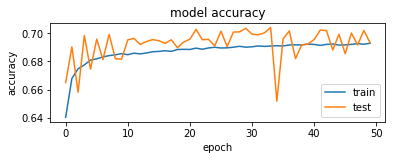

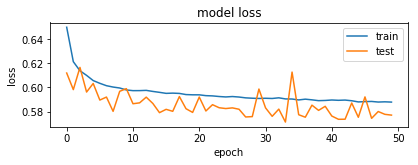

F1_score =  0.6955287851325519
confusion matrix
 [[35910 33576]
 [17501 85679]]
Test Score =  0.5715632119838024
Test accuracy =  0.7041861165514741


In [10]:
filepath, f1_value, conf, ts, ta = model(train_data, test_data, train_label, test_label)